In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

2024-09-27 15:16:49.324124: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 15:16:49.430144: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 15:16:50.205678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 15:16:53.050309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
base_train_csv = pd.read_csv('bases/petr4_treinamento.csv')
base_train_csv.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [4]:
base_test_csv = pd.read_csv('bases/petr4_teste.csv')
base_test_csv.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [5]:
base_train_csv = base_train_csv.dropna()

In [20]:
base_train = base_train_csv.iloc[:, 1:7].values
base_train

array([[1.9990000e+01, 2.0209999e+01, 1.9690001e+01, 1.9690001e+01,
        1.8086271e+01, 3.0182600e+07],
       [1.9809999e+01, 2.0400000e+01, 1.9700001e+01, 2.0400000e+01,
        1.8738441e+01, 3.0552600e+07],
       [2.0330000e+01, 2.0620001e+01, 2.0170000e+01, 2.0430000e+01,
        1.8766001e+01, 3.6141000e+07],
       ...,
       [1.5990000e+01, 1.6139999e+01, 1.5980000e+01, 1.6049999e+01,
        1.6017963e+01, 2.3552200e+07],
       [1.6100000e+01, 1.6129999e+01, 1.6000000e+01, 1.6100000e+01,
        1.6067865e+01, 1.9011500e+07],
       [1.6100000e+01, 1.6100000e+01, 1.6100000e+01, 1.6100000e+01,
        1.6067865e+01, 0.0000000e+00]])

In [21]:
normalizer = MinMaxScaler(feature_range=(0, 1))
base_train_ = normalizer.fit_transform(base_train)

In [22]:
prevs_normalizer = MinMaxScaler(feature_range=(0, 1))
base_train_ = prevs_normalizer.fit_transform(base_train[:, 0:1])

In [23]:
base_train_

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [24]:
base_train_.shape

(1242, 1)

In [25]:
antecipator = 90

In [26]:
x_train = [] # Previsores
y_train = [] # Preços reais
for i in range(antecipator, base_train_.shape[0]): # 90 preços anteriores para prever intervalo atual
    x_train.append(base_train_[i - antecipator:i, 0:base_train_.shape[1]])
    y_train.append(base_train_[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [27]:
x_train

array([[[0.76501938],
        [0.7562984 ],
        [0.78149225],
        ...,
        [0.74273261],
        [0.74127907],
        [0.74224806]],

       [[0.7562984 ],
        [0.78149225],
        [0.78875969],
        ...,
        [0.74127907],
        [0.74224806],
        [0.76114341]],

       [[0.78149225],
        [0.78875969],
        [0.77083338],
        ...,
        [0.74224806],
        [0.76114341],
        [0.76114341]],

       ...,

       [[0.46414729],
        [0.46414729],
        [0.46850775],
        ...,
        [0.55959302],
        [0.55959302],
        [0.55959302]],

       [[0.46414729],
        [0.46850775],
        [0.47141473],
        ...,
        [0.55959302],
        [0.55959302],
        [0.57122093]],

       [[0.46850775],
        [0.47141473],
        [0.46317829],
        ...,
        [0.55959302],
        [0.57122093],
        [0.57655039]]])

In [28]:
x_train.shape

(1152, 90, 1)

In [29]:
y_train.shape

(1152,)

In [30]:
x_train.shape[2]

1

In [31]:
model = Sequential()

model.add(Input((x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=1, activation='linear'))

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,451 (435.36 KB)

 Trainable params: 111,451 (435.36 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [23]:
early_stop = EarlyStopping(
    monitor='loss',
    min_delta=1e-10,
    patience=10,
    verbose=True
)

In [22]:
reduce_plateau = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
)

In [36]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/weights_prev_one.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

In [37]:
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop, reduce_plateau, model_checkpoint])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - loss: 0.0545 - mean_absolute_error: 0.1763
Epoch 1: loss improved from inf to 0.02975, saving model to checkpoints/weights_prev_one.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 632ms/step - loss: 0.0538 - mean_absolute_error: 0.1751 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0123 - mean_absolute_error: 0.0835
Epoch 2: loss improved from 0.02975 to 0.01392, saving model to checkpoints/weights_prev_one.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - loss: 0.0124 - mean_absolute_error: 0.0836 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0131 - mean_absolute_error: 0.0915
Epoch 3: loss improved from 0.01392 to 0.01199, saving model to checkpoints/weights_prev_one.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - loss: 0.0131 - mean_absolute_error: 0.0913 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.0112 - mean_absol

In [38]:
y_test = base_test_csv.iloc[:, 1:2].values
y_test

array([[16.190001],
       [16.49    ],
       [16.780001],
       [16.700001],
       [16.74    ],
       [17.030001],
       [16.92    ],
       [16.879999],
       [17.040001],
       [17.32    ],
       [17.35    ],
       [17.92    ],
       [18.35    ],
       [18.309999],
       [18.26    ],
       [18.4     ],
       [18.42    ],
       [19.34    ],
       [19.620001],
       [19.67    ],
       [19.77    ],
       [19.74    ]])

In [39]:
frames = [base_train_csv, base_test_csv]
frames

[            Date       Open       High        Low      Close  Adj Close  \
 0     2013-01-02  19.990000  20.209999  19.690001  19.690001  18.086271   
 1     2013-01-03  19.809999  20.400000  19.700001  20.400000  18.738441   
 2     2013-01-04  20.330000  20.620001  20.170000  20.430000  18.766001   
 3     2013-01-07  20.480000  20.670000  19.950001  20.080000  18.444506   
 4     2013-01-08  20.110001  20.230000  19.459999  19.500000  17.911745   
 ...          ...        ...        ...        ...        ...        ...   
 1240  2017-12-25  15.750000  15.750000  15.750000  15.750000  15.718563   
 1241  2017-12-26  15.750000  15.990000  15.690000  15.970000  15.938125   
 1242  2017-12-27  15.990000  16.139999  15.980000  16.049999  16.017963   
 1243  2017-12-28  16.100000  16.129999  16.000000  16.100000  16.067865   
 1244  2017-12-29  16.100000  16.100000  16.100000  16.100000  16.067865   
 
           Volume  
 0     30182600.0  
 1     30552600.0  
 2     36141000.0  
 3    

In [40]:
base_complete = pd.concat(frames)
base_complete

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0


In [41]:
base_complete = base_complete.drop('Date', axis=1)

In [42]:
input = base_complete[len(base_complete) - len(base_test_csv) - antecipator:].values
input

array([[1.3930000e+01, 1.4030000e+01, 1.3760000e+01, 1.3870000e+01,
        1.3842316e+01, 2.7208100e+07],
       [1.3760000e+01, 1.3850000e+01, 1.3680000e+01, 1.3850000e+01,
        1.3822356e+01, 2.7306400e+07],
       [1.3790000e+01, 1.3900000e+01, 1.3440000e+01, 1.3450000e+01,
        1.3423154e+01, 5.8871700e+07],
       [1.3530000e+01, 1.3770000e+01, 1.3470000e+01, 1.3650000e+01,
        1.3622754e+01, 8.2909400e+07],
       [1.3850000e+01, 1.4190000e+01, 1.3820000e+01, 1.4020000e+01,
        1.3992017e+01, 6.0260300e+07],
       [1.3960000e+01, 1.4180000e+01, 1.3940000e+01, 1.4170000e+01,
        1.4141717e+01, 1.8139300e+07],
       [1.4570000e+01, 1.4650000e+01, 1.4230000e+01, 1.4410000e+01,
        1.4381238e+01, 5.6476800e+07],
       [1.4650000e+01, 1.5020000e+01, 1.4510000e+01, 1.5020000e+01,
        1.4990021e+01, 6.8418200e+07],
       [1.5020000e+01, 1.5020000e+01, 1.5020000e+01, 1.5020000e+01,
        1.4990021e+01, 0.0000000e+00],
       [1.5100000e+01, 1.5150000e+01,

In [43]:
input = normalizer.transform(input)
input

array([[0.47141473, 0.47309743, 0.49334698, 0.47495091, 0.47495089,
        0.03892707],
       [0.46317829, 0.46437227, 0.48925281, 0.47396859, 0.47396857,
        0.03906771],
       [0.46463178, 0.46679593, 0.47697032, 0.45432222, 0.45432219,
        0.0842287 ],
       [0.45203488, 0.46049443, 0.47850563, 0.46414541, 0.46414533,
        0.11861983],
       [0.46753876, 0.48085313, 0.4964176 , 0.48231829, 0.48231829,
        0.08621539],
       [0.47286822, 0.4803684 , 0.50255885, 0.48968568, 0.48968565,
        0.02595219],
       [0.50242248, 0.50315075, 0.5174002 , 0.5014735 , 0.50147347,
        0.08080228],
       [0.50629845, 0.5210858 , 0.53172979, 0.53143421, 0.53143421,
        0.09788703],
       [0.52422481, 0.5210858 , 0.55783009, 0.53143421, 0.53143421,
        0.        ],
       [0.52810078, 0.5273873 , 0.54094166, 0.51620828, 0.51620824,
        0.05198851],
       [0.51744186, 0.52253999, 0.54708291, 0.52996073, 0.52996068,
        0.04995475],
       [0.52228682, 0

In [44]:
x_test = [input[i-antecipator:i, 0:6] for i in range(antecipator, input.shape[0])]
x_test = np.array(x_test)
x_test

array([[[0.47141473, 0.47309743, 0.49334698, 0.47495091, 0.47495089,
         0.03892707],
        [0.46317829, 0.46437227, 0.48925281, 0.47396859, 0.47396857,
         0.03906771],
        [0.46463178, 0.46679593, 0.47697032, 0.45432222, 0.45432219,
         0.0842287 ],
        ...,
        [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
         0.03369652],
        [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
         0.02720006],
        [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
         0.        ]],

       [[0.46317829, 0.46437227, 0.48925281, 0.47396859, 0.47396857,
         0.03906771],
        [0.46463178, 0.46679593, 0.47697032, 0.45432222, 0.45432219,
         0.0842287 ],
        [0.45203488, 0.46049443, 0.47850563, 0.46414541, 0.46414533,
         0.11861983],
        ...,
        [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
         0.02720006],
        [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.584

In [45]:
x_test.shape

(22, 90, 6)

In [46]:
prevs = model.predict(x_test)
prevs

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 6 and 1 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_1, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [22,6], [1,400].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(22, 6), dtype=float32)
  • states=('tf.Tensor(shape=(22, 100), dtype=float32)', 'tf.Tensor(shape=(22, 100), dtype=float32)')
  • training=False

In [77]:
prevs = prevs_normalizer.inverse_transform(prevs)
prevs

array([[16.06155 ],
       [16.18891 ],
       [16.309292],
       [16.430826],
       [16.551216],
       [16.67031 ],
       [16.786053],
       [16.8803  ],
       [16.957146],
       [17.023739],
       [17.091032],
       [17.168617],
       [17.291317],
       [17.463486],
       [17.663248],
       [17.865534],
       [18.038857],
       [18.205372],
       [18.404268],
       [18.642569],
       [18.900913],
       [19.131927]], dtype=float32)

In [78]:
prevs.mean(), y_test.mean()

(17.351204, 17.87454563636364)

In [79]:
mean_absolute_error(prevs, y_test)

0.5233693890769264

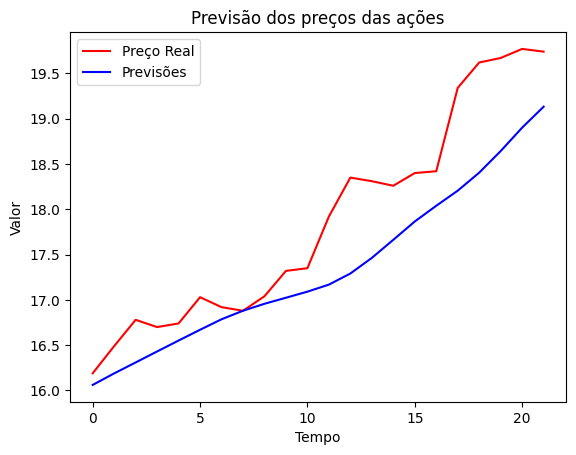

In [80]:
plt.plot(y_test, color='red', label='Preço Real')
plt.plot(prevs, color='blue', label='Previsões')
plt.title('Previsão dos preços das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend();

# **Multiplas Saídas**

In [6]:
base_train = base_train_csv.iloc[:, 1:2].values
base_value_max = base_train_csv.iloc[:, 2:3].values

In [7]:
pd.DataFrame(base_train)

,0
0,19.990000
1,19.809999
2,20.330000
3,20.480000
4,20.110001
...,...
1237,15.750000
1238,15.750000
1239,15.990000
1240,16.100000


In [8]:
pd.DataFrame(base_value_max)

,0
0,20.209999
1,20.400000
2,20.620001
3,20.670000
4,20.230000
...,...
1237,15.750000
1238,15.990000
1239,16.139999
1240,16.129999


In [9]:
normalizer = MinMaxScaler(feature_range=(0, 1))
base_train = normalizer.fit_transform(base_train)
base_value_max = normalizer.fit_transform(base_value_max)

In [10]:
pd.DataFrame(base_train)

,0
0,0.765019
1,0.756298
2,0.781492
3,0.788760
4,0.770833
...,...
1237,0.559593
1238,0.559593
1239,0.571221
1240,0.576550


In [11]:
pd.DataFrame(base_value_max)

,0
0,0.772661
1,0.781871
2,0.792535
3,0.794959
4,0.773631
...,...
1237,0.556471
1238,0.568105
1239,0.575376
1240,0.574891


In [12]:
antec = 90

In [13]:
base_train.shape

(1242, 1)

In [14]:
x_train = []
y_train1 = []
y_train2 = []

for i in range(antec, base_train.shape[0]):
    x_train.append(base_train[i - antec:i, 0])
    y_train1.append(base_train[i, 0])
    y_train2.append(base_value_max[i, 0])

x_train, y_train1, y_train2 = np.array(x_train), np.array(y_train1), np.array(y_train2)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
x_train.shape

(1152, 90, 1)

In [16]:
y_train = np.column_stack((y_train1, y_train2))
y_train

array([[0.76114341, 0.76490543],
       [0.76114341, 0.7746001 ],
       [0.77470935, 0.78090155],
       ...,
       [0.57122093, 0.57537562],
       [0.57655039, 0.57489089],
       [0.57655039, 0.57343674]])

In [17]:
y_train.shape

(1152, 2)

In [18]:
model = Sequential()

model.add(Input((x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='linear'))

In [19]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [20]:
model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/weights_prev_multiple.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

In [24]:
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[reduce_plateau, model_checkpoint, early_stop])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0657 - mean_absolute_error: 0.1871
Epoch 1: loss improved from inf to 0.03420, saving model to checkpoints/weights_prev_multiple.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 0.0649 - mean_absolute_error: 0.1857 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0206 - mean_absolute_error: 0.1128
Epoch 2: loss improved from 0.03420 to 0.01842, saving model to checkpoints/weights_prev_multiple.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 0.0206 - mean_absolute_error: 0.1126 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0139 - mean_absolute_error: 0.0921
Epoch 3: loss improved from 0.01842 to 0.01354, saving model to checkpoints/weights_prev_multiple.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - loss: 0.0139 - mean_absolute_error: 0.0920 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0136

In [31]:
x_open = base_test_csv.iloc[:, 1:2].values
x_high = base_test_csv.iloc[:, 2:3].values

In [34]:
base_complete = pd.concat((base_train_csv['Open'], base_test_csv['Open']), axis=0)
inputs = base_complete[len(base_complete) - len(base_test_csv) - antec:].values
inputs = inputs.reshape(-1, 1)
inputs = normalizer.transform(inputs)

In [36]:
x_test = [inputs[i-antec:i, 0:6] for i in range(antec, inputs.shape[0])]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [38]:
prevs = model.predict(x_test)
prevs = normalizer.inverse_transform(prevs)
prevs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


array([[15.748248, 15.940084],
       [15.883489, 16.076231],
       [16.010841, 16.204365],
       [16.144493, 16.339174],
       [16.280962, 16.476954],
       [16.409538, 16.606667],
       [16.53242 , 16.730669],
       [16.641865, 16.841005],
       [16.726898, 16.926489],
       [16.78925 , 16.98904 ],
       [16.846546, 17.046835],
       [16.909597, 17.110788],
       [17.006304, 17.20936 ],
       [17.163242, 17.369427],
       [17.371777, 17.581593],
       [17.598293, 17.811163],
       [17.813232, 18.028103],
       [17.994276, 18.210005],
       [18.17363 , 18.390516],
       [18.38086 , 18.599909],
       [18.616158, 18.837986],
       [18.861364, 19.08588 ]], dtype=float32)

In [ ]:
prevs.mean(), y_test.mean()

In [ ]:
mean_absolute_error(prevs, y_test)

In [ ]:
plt.plot(y_test, color='red', label='Preço Real')
plt.plot(prevs, color='blue', label='Previsões')
plt.title('Previsão dos preços das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend();